 Objective: Train a model to detect fraudulent providers with suspiciously high claim volumes in short durations using inpatient + outpatient data

In [4]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
# load outpatient data 
# Replace these paths with the correct file paths on your machine
df_fraud = pd.read_csv("/Users/kalibraun/dev/healthcare/fraudTrain.csv.xls")
df_in = pd.read_csv("/Users/kalibraun/dev/healthcare/inpatientData.csv")
df_out = pd.read_csv("/Users/kalibraun/dev/healthcare/outpatientData.csv")

In [ ]:
# look at df_fraud, should be yes and no in potentialfraud column
print(df_fraud)

      Provider PotentialFraud
0     PRV51001             No
1     PRV51003            Yes
2     PRV51004             No
3     PRV51005            Yes
4     PRV51007             No
...        ...            ...
5405  PRV57759             No
5406  PRV57760             No
5407  PRV57761             No
5408  PRV57762             No
5409  PRV57763             No

[5410 rows x 2 columns]


In [ ]:
print(df_in.columns)
print(df_out.columns)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')
Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagn

In [8]:
# convert df_fraud from bool to int
df_fraud["PotentialFraud"] = df_fraud["PotentialFraud"].map({"Yes": 1, "No": 0})
print(df_fraud)

      Provider  PotentialFraud
0     PRV51001               0
1     PRV51003               1
2     PRV51004               0
3     PRV51005               1
4     PRV51007               0
...        ...             ...
5405  PRV57759               0
5406  PRV57760               0
5407  PRV57761               0
5408  PRV57762               0
5409  PRV57763               0

[5410 rows x 2 columns]


Preprocessing and Feature Engineering

In [9]:
# create claim duration column
# convert date columns to datetime format 
df_in["ClaimStartDt"] = pd.to_datetime(df_in["ClaimStartDt"])
df_in["ClaimEndDt"] = pd.to_datetime(df_in["ClaimEndDt"])

df_out["ClaimStartDt"] = pd.to_datetime(df_out["ClaimStartDt"])
df_out["ClaimEndDt"] = pd.to_datetime(df_out["ClaimEndDt"])

# create new duration column in days
df_in["ClaimDuration"] = (df_in["ClaimEndDt"] - df_in["ClaimStartDt"]).dt.days
df_out["ClaimDuration"] = (df_out["ClaimEndDt"] - df_out["ClaimStartDt"]).dt.days

In [10]:
# aggregate inpatient data by provider 
in_agg = df_in.groupby("Provider").agg(
    InpatientClaimCount=("Provider", "count"),
    InpatientTotalReimbursed=("InscClaimAmtReimbursed", "sum"),
    InpatientAvgDuration=("ClaimDuration", "mean")
).reset_index()

# Aggregate outpatient data by provider
out_agg = df_out.groupby("Provider").agg(
    OutpatientClaimCount=("Provider", "count"),
    OutpatientTotalReimbursed=("InscClaimAmtReimbursed", "sum"),
    OutpatientAvgDuration=("ClaimDuration", "mean")
).reset_index()

# Merge inpatient + outpatient
provider_features = pd.merge(in_agg, out_agg, on="Provider", how="outer").fillna(0)

# Merge with fraud labels
df_fraud["PotentialFraud"] = df_fraud["PotentialFraud"]
df = pd.merge(provider_features, df_fraud, on="Provider", how="inner")

In [11]:
print(df.head())

   Provider  InpatientClaimCount  InpatientTotalReimbursed  \
0  PRV51001                  5.0                   97000.0   
1  PRV51003                 62.0                  573000.0   
2  PRV51004                  0.0                       0.0   
3  PRV51005                  0.0                       0.0   
4  PRV51007                  3.0                   19000.0   

   InpatientAvgDuration  OutpatientClaimCount  OutpatientTotalReimbursed  \
0              5.000000                  20.0                     7640.0   
1              5.161290                  70.0                    32670.0   
2              0.000000                 149.0                    52170.0   
3              0.000000                1165.0                   280910.0   
4              5.333333                  69.0                    14710.0   

   OutpatientAvgDuration  PotentialFraud  
0               0.550000               0  
1               2.357143               1  
2               1.429530               0 

Train Test Split

In [12]:
features = [
    'InpatientClaimCount', 'InpatientTotalReimbursed', 'InpatientAvgDuration',
    'OutpatientClaimCount', 'OutpatientTotalReimbursed', 'OutpatientAvgDuration'
]
X = df[features]
y = df["PotentialFraud"]

In [13]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf.fit(X_train, y_train)

print("XGBoost Accuracy:", xgb_clf.score(X_test, y_test))

XGBoost Accuracy: 0.9386548410938654


/Users/kalibraun/dev/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:07:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluate Model

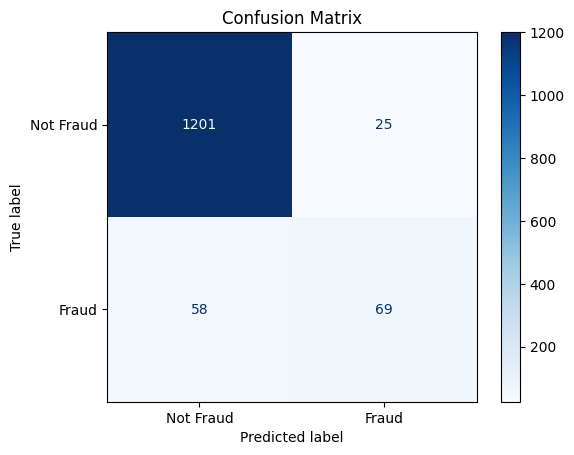

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.95      0.98      0.97      1226
       Fraud       0.73      0.54      0.62       127

    accuracy                           0.94      1353
   macro avg       0.84      0.76      0.80      1353
weighted avg       0.93      0.94      0.93      1353



In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = xgb_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

Visualizations

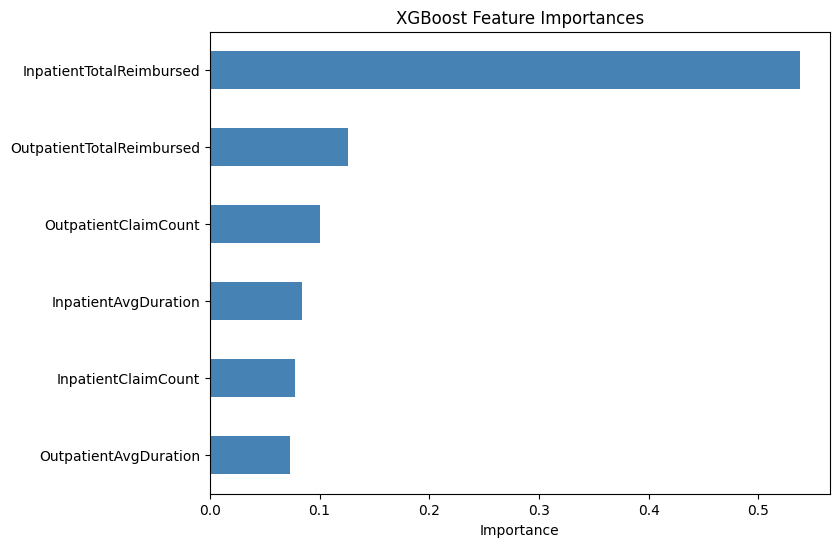

In [15]:
# Visualize Feature Importance
importances = pd.Series(xgb_clf.feature_importances_, index=features)

plt.figure(figsize=(8, 6))
importances.sort_values().plot(kind="barh", color="steelblue")
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.show()

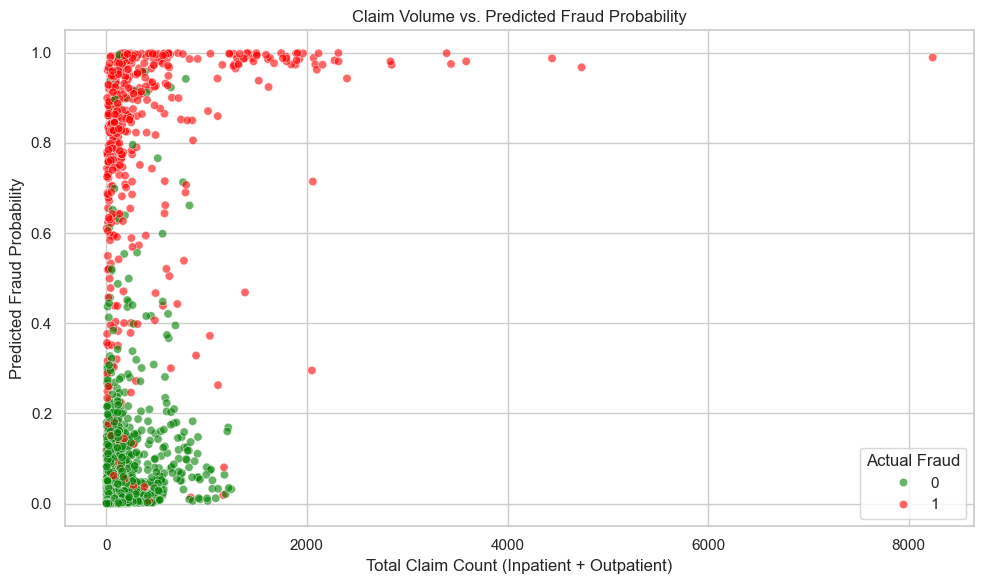

In [16]:
# Scatter Plot: Claim Volume vs Fraud Probability
sns.set(style = "whitegrid")

# Get fraud probabilities from the model
df["FraudProbability"] = xgb_clf.predict_proba(X)[:, 1]  # Probability of class 1 (fraud)

# create totalcaimcount column
df["TotalClaimCount"] = df["InpatientClaimCount"] + df["OutpatientClaimCount"]

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x= "TotalClaimCount",  
    y="FraudProbability",
    hue="PotentialFraud",
    palette={0: "green", 1: "red"}, # geen = no fraud, red = fraud
    alpha=0.6
)

plt.title("Claim Volume vs. Predicted Fraud Probability")
plt.xlabel("Total Claim Count (Inpatient + Outpatient)")
plt.ylabel("Predicted Fraud Probability")
plt.legend(title="Actual Fraud")
plt.grid(True)
plt.tight_layout()
plt.show()


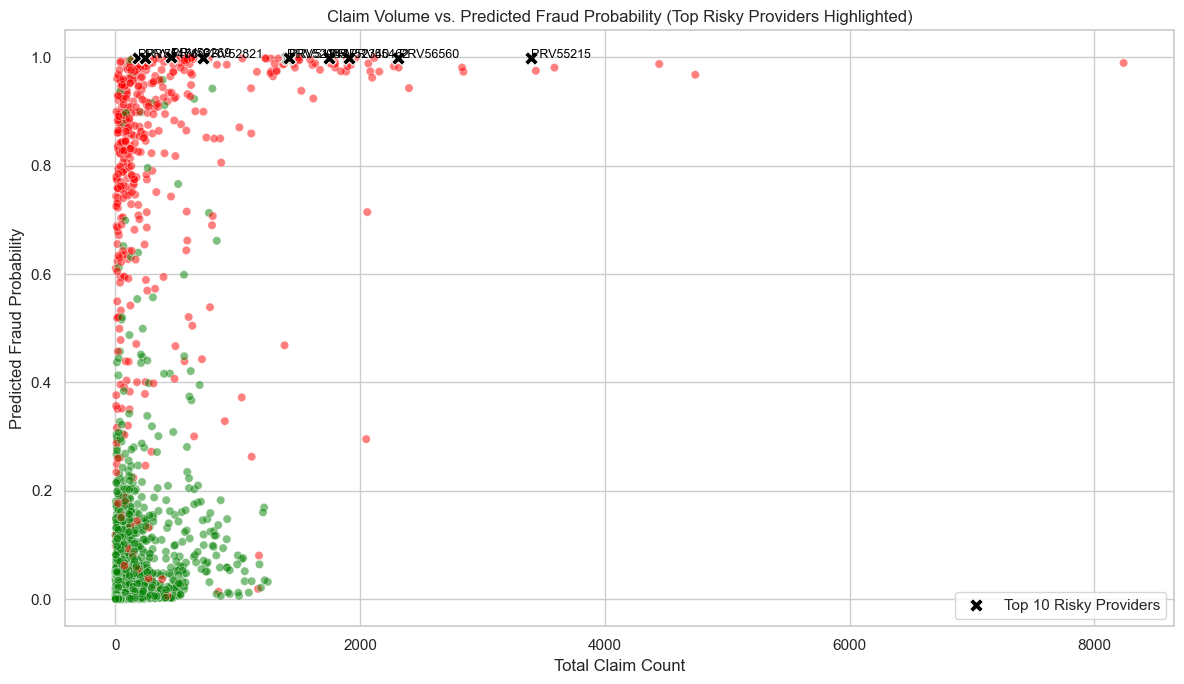

In [17]:
# highlight top N providers with highest fraud probability 

# Get top N riskiest providers
top_n = 10
top_providers = df.sort_values("FraudProbability", ascending=False).head(top_n)

# Base scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x="TotalClaimCount",
    y="FraudProbability",
    hue="PotentialFraud",
    palette={0: "green", 1: "red"},
    alpha=0.5,
    legend=False
)

# Highlight top N
sns.scatterplot(
    data=top_providers,
    x="TotalClaimCount",
    y="FraudProbability",
    color="black",
    s=100,
    marker="X",
    label=f"Top {top_n} Risky Providers"
)

# Annotate provider IDs
for _, row in top_providers.iterrows():
    plt.text(
        row["TotalClaimCount"] + 1,  # Slight offset
        row["FraudProbability"],
        row["Provider"],
        fontsize=9,
        color="black"
    )

plt.title("Claim Volume vs. Predicted Fraud Probability (Top Risky Providers Highlighted)")
plt.xlabel("Total Claim Count")
plt.ylabel("Predicted Fraud Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Black "X" markers show the highest-risk providers.
Their IDs are annotated for clarity.
You can change top_n to highlight more/less risky ones.

In [18]:
# plotly Version: Interactive Scatter Plot
import plotly.express as px

# Make sure TotalClaimCount is calculated
df["TotalClaimCount"] = df["InpatientClaimCount"] + df["OutpatientClaimCount"]

# Optional: Label fraud class as string for prettier legend
df["FraudLabel"] = df["PotentialFraud"].map({0: "Not Fraud", 1: "Fraud"})

# Create interactive scatter plot
fig = px.scatter(
    df,
    x="TotalClaimCount",
    y="FraudProbability",
    color="FraudLabel",
    hover_data=["Provider", "TotalClaimCount", "FraudProbability"],
    title="Interactive: Claim Volume vs Predicted Fraud Probability",
    labels={"TotalClaimCount": "Total Claims", "FraudProbability": "Fraud Probability"},
    color_discrete_map={"Fraud": "red", "Not Fraud": "green"},
    opacity=0.6
)

# Highlight top N risky providers
top_n = 10
top_providers = df.nlargest(top_n, "FraudProbability")

fig.add_scatter(
    x=top_providers["TotalClaimCount"],
    y=top_providers["FraudProbability"],
    mode="markers+text",
    marker=dict(size=12, color="black", symbol="x"),
    text=top_providers["Provider"],
    textposition="top center",
    name=f"Top {top_n} Risky Providers"
)

fig.update_layout(legend_title_text="Actual Fraud Label", height=600)

fig.show()


Ways to improving model 
- Feature Engineering 
- Class Weights or Sampling
- Hyperparameter Tuning
- More Evaluation Metrics
- Model Stacking / Blending
- SHAP or Feature Importance

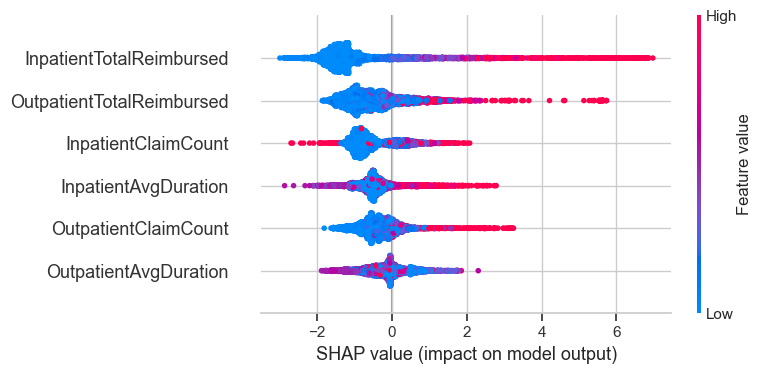

In [19]:
# shap - This can reveal what makes providers look suspicious 
import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [22]:
# more evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score

y_proba = xgb_clf.predict_proba(X_test)[:, 1] # predicted probabilities

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1226
           1       0.73      0.54      0.62       127

    accuracy                           0.94      1353
   macro avg       0.84      0.76      0.80      1353
weighted avg       0.93      0.94      0.93      1353

ROC AUC: 0.9476114629227628


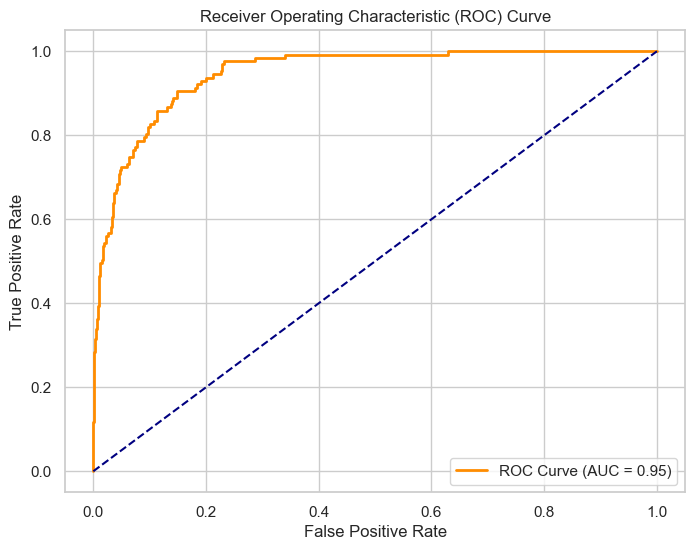

In [ ]:
# roc curve plot
# the closer the curve is to the top left corner, the better your model is
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get false positive rate, true positive rate, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
